In [105]:
#Here are the selected imports

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from icrawler.builtin import GoogleImageCrawler
import matplotlib.image as mpimg
import os
from random import randrange
import cv2
import random
from PIL import Image
import json
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import decode_image, read_file
from torchvision import tv_tensors
from matplotlib.patches import Rectangle



torch.manual_seed(1)



In [102]:
#Download Some Background image

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['Las Vegas', 'Burj al arab', 'Seychelles', 'Azores', 'Canary islands', 'Budapest', 'Castle', 'Park', "Balaton", 'Porto']:
    google_crawler.crawl(
        keyword=keyword, max_num=20, file_idx_offset='auto')

2024-10-13 20:06:04,924 - INFO - icrawler.crawler - start crawling...
2024-10-13 20:06:04,924 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-13 20:06:04,926 - INFO - feeder - thread feeder-001 exit
2024-10-13 20:06:04,927 - INFO - icrawler.crawler - starting 2 parser threads...
2024-10-13 20:06:04,928 - INFO - icrawler.crawler - starting 4 downloader threads...
2024-10-13 20:06:05,867 - INFO - parser - parsing result page https://www.google.com/search?q=Las+Vegas&ijn=0&start=0&tbs=&tbm=isch
2024-10-13 20:06:06,500 - ERROR - downloader - Response status code 404, file https://as1.ftcdn.net/v2/jpg
2024-10-13 20:06:06,507 - INFO - downloader - image #1	https://media.tacdn.com/media/attractions-content--1x-1/12/85/9e/df.jpg
2024-10-13 20:06:06,533 - INFO - downloader - image #2	https://dynamic-media-cdn.tripadvisor.com/media/photo-o/2a/34/2d/28/caption.jpg
2024-10-13 20:06:06,805 - INFO - downloader - image #3	https://media.cnn.com/api/v1/images/stellar/prod/180313182911-

KeyboardInterrupt: 

2024-10-13 20:06:25,177 - INFO - downloader - image #9	https://dcontent.inviacdn.net/shared/img/web-800x600/2020/9/24/d0/26646318-burj-al-arab.jpg
2024-10-13 20:06:25,468 - INFO - downloader - image #10	https://cosmopoliclan.com/wp-content/uploads/2022/04/CosmopoliClan-Dubai-Inside-Burj-al-Arab-Jumeirah-Inside-Burj-al-Arab-Dubai-4.jpg
2024-10-13 20:06:25,680 - INFO - downloader - image #11	https://content.satimagingcorp.com/static/galleryimages/worldview-2-burj-al-arab.jpg
2024-10-13 20:06:25,951 - INFO - downloader - image #12	https://dubaitickets.tours/wp-content/uploads/2024/04/burj-al-arab-tour-dubai-9.jpg
2024-10-13 20:06:26,228 - INFO - downloader - image #13	https://cdn.mahlatini.com/Clear-kayak-tour-Image-courtesy-of-Michel-Denousse-Tourism-Seychelles.jpg
2024-10-13 20:06:26,360 - INFO - downloader - image #14	http://admin.seychelles.com/sites/default/files/2024-01/About_Seychelles.jpg
2024-10-13 20:06:26,812 - INFO - downloader - image #15	https://www.dubaitravelguide.info/wp-

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.png', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.png', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '000071.jpg', '0000

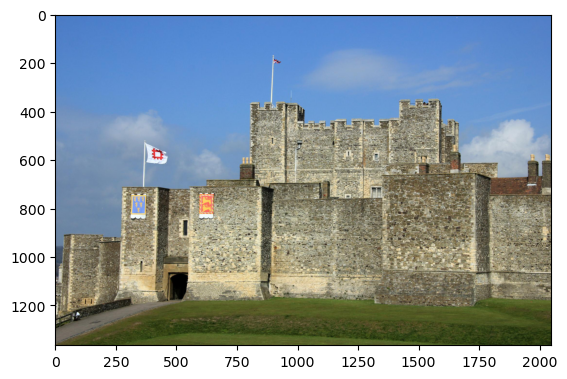

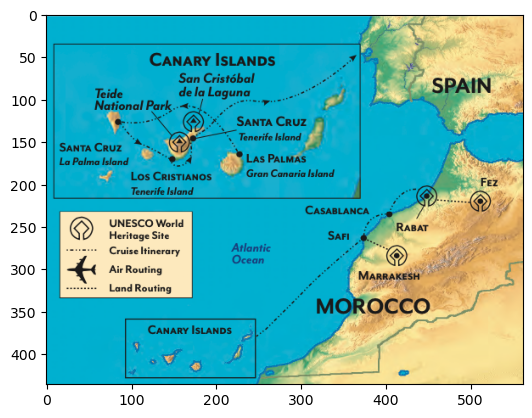

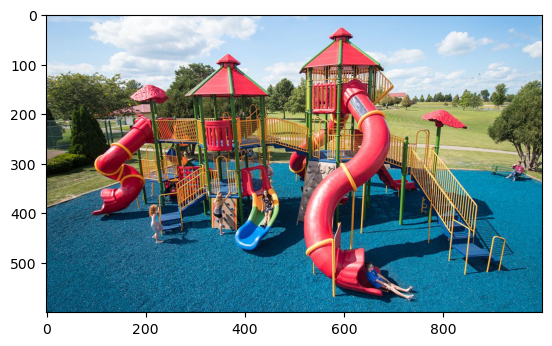

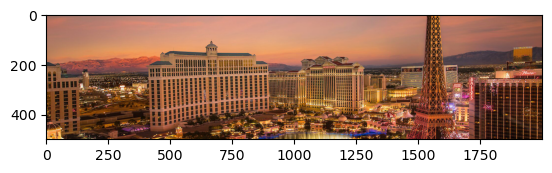

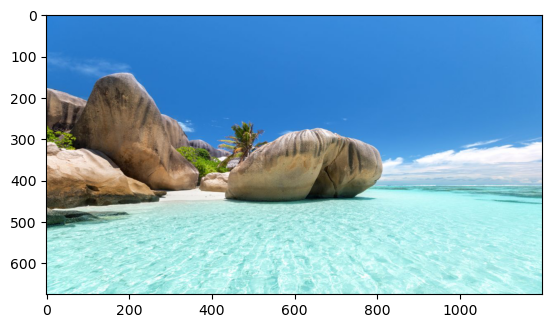

In [3]:
directory = 'background'
ImageNames = os.listdir(directory)
print(ImageNames)

def display_sample_images(directory: str, ImageName: str) -> None:
    image = mpimg.imread(f"{directory}\\{ImageName}")
    plt.figure()
    plt.imshow(image)

#This is going to show 5 random pictures
for i in range(5):
    randomNumber = randrange(len(ImageNames))
    display_sample_images(directory, ImageNames[randomNumber])

In [94]:

def GenerateIamgesandBoundingBoxes(ImageNames: list):
    #We create a folder for the New Images
    ObjBGPath = "OBJBG"
    if not os.path.exists(ObjBGPath):
        os.makedirs(ObjBGPath)
    OBJBGPic = "Images"
    if not os.path.exists(f"{ObjBGPath}\\{OBJBGPic}"):
        os.makedirs(f"{ObjBGPath}\\{OBJBGPic}")
    OBJBGBounding = "BoundingBox"
    if not os.path.exists(f"{ObjBGPath}\\{OBJBGBounding}"):
        os.makedirs(f"{ObjBGPath}\\{OBJBGBounding}")


    ObjectDirectory = 'Object'
    #Gather all the names of the objects
    ObjectNames = os.listdir(ObjectDirectory)

    #We suffle the list of background 
    random.shuffle(ImageNames)

    ObjectID = {
        ObjectNames[0] : 1,
        ObjectNames[1] : 2,
        ObjectNames[2] : 3
    }


    for i in ImageNames:
        #Open the images
        BackgroundImage = Image.open(f"{directory}\\{i}")
        
        #We choose a random Statue
        randomStatue = randrange(len(ObjectNames))
        StatueImage = Image.open(f"{ObjectDirectory}\\{ObjectNames[randomStatue]}")

        #We get the Image Size and scale them down randomly
        w, h = StatueImage.size
        bgw, bgh = BackgroundImage.size
        randomScaleNumber = round(random.uniform(0.1, 0.3), 2)
        StatueImage.thumbnail((w*randomScaleNumber, h*randomScaleNumber))

        #We resize the Image to be smaller and for every image to be the same size
        BackgroundImage = BackgroundImage.resize((520, 520))

        #We get the now Modified Statue and BG size
        bgw, bgh = BackgroundImage.size
        w, h = StatueImage.size

        #We define some random start points in the BG where we will insert the files
        randomPlaceonBGWidth = random.randint(0, bgw-w)
        randomPlaceonBGHeight = random.randint(0, bgh-h)


        #We Paste the images to the BG
        BackgroundImage.paste(StatueImage, (randomPlaceonBGWidth,randomPlaceonBGHeight), StatueImage.convert('RGBA'))
        class_id = ObjectID[ObjectNames[randomStatue]]
        #Create the Bounding box text
        # class_id = ObjectID[ObjectNames[randomStatue]]
        # x_center = (randomPlaceonBGWidth + w / 2) / bgw
        # y_center = (randomPlaceonBGHeight + h / 2) / bgh
        # width = w / bgw
        # height = h / bgh
        # BoundingBox = {
        #     "class_id": class_id,
        #     "x_center": x_center,
        #     "y_center": y_center,
        #     "width": width,
        #     "height": height
        # }

        #This is for Pytorch tv_tensors._bounding_boxis 'CXCYWH' format
        x_center = int(randomPlaceonBGWidth + (w / 2))
        y_center = int(randomPlaceonBGHeight + (h / 2))
        width = w
        height = h
        BoundingBox = {
            "class_id": class_id,
            "x_center": x_center,
            "y_center": y_center,
            "width": width,
            "height": height
        }

        

        open_cv_image = np.array(BackgroundImage)
        #To convert RGB to BGR
        try:
            open_cv_image = open_cv_image[:, :, ::-1].copy()

            with open(f"{ObjBGPath}\\{OBJBGBounding}\\{i[:-4]}.json", "w") as output:
                json.dump(BoundingBox, output, indent=4)
            cv2.imwrite(f"{ObjBGPath}\\{OBJBGPic}\\{i[:-4]}.jpg", open_cv_image)
        except:
            print(f"This picture is png: {i}")





In [95]:
GenerateIamgesandBoundingBoxes(ImageNames)

This picture is png: 000065.png
This picture is png: 000047.png


In [159]:
def GenerateTrainValTest(TypeData: str, numImages: int, PathofImages: list, PathofBB = list) -> None:


    PATHPic= 'OBJBG//Images'
    PATHBoundingBox = 'OBJBG//BoundingBox'

    #Where to output the images
    BasePath = "root//dataset//"
    if not os.path.exists(BasePath):
        os.makedirs(BasePath)
    

    match TypeData:
        case "train":
            OutPathIm = os.path.join(BasePath,"train//images")
            OutPathBB = os.path.join(BasePath,"train//labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            filename = "train"
        
        case "val":
            OutPathIm = os.path.join(BasePath,"val//images")
            OutPathBB = os.path.join(BasePath,"val//labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            filename = "val"
        
        case "test":
            OutPathIm = os.path.join(BasePath,"test//images")
            OutPathBB = os.path.join(BasePath,"test//labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            filename = "test"
        

    
    numberofimages = len(PathofImages)
    NumberAugIm = int(numImages/numberofimages)
    #We need a for loop to go through every image, and create copies of it with augmentation and save them
    ProcessImageNumber = 0
    for i in range(numberofimages):

        # Read the image file into a tensor of bytes
        useImage = os.path.join(PATHPic, PathofImages[i])
        useBB = os.path.join(PATHBoundingBox, PathofBB[i])

        #Load the given image
        img_path = Path(useImage)
        #Load the given bb
        with open(useBB, 'r') as file:
            BoundingBox = json.load(file)


        # Use read_file to load the image content
        img = decode_image(read_file(img_path))

        boxes = tv_tensors.BoundingBoxes(
            [[BoundingBox['x_center'], BoundingBox['y_center'], BoundingBox['width'], BoundingBox['height']]],  # Format: [center_x, center_y, width, height]
            format='CXCYWH', 
            canvas_size=(img.shape[1], img.shape[2])  # Canvas size is (height, width)
        )
        for j in range(NumberAugIm):
            transforms = v2.Compose([
                v2.ToDtype(torch.float32, scale=True),
                v2.RandomPhotometricDistort(p=0.5),
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomAffine(random.randint(0, 360)),
                v2.RandomVerticalFlip(p=0.5),
                v2.RandomPerspective(p=0.1),
                v2.GaussianNoise(random.uniform(0,0.3)),
                v2.GaussianBlur(random.randrange(1, 6, 2))
            ])

            out_img, out_boxes = transforms(img, boxes)
            # Convert out_img to a NumPy array

            # Manually convert boxes from CXCYWH to XYXY
            # out_boxes is still in CXCYWH format
            #boxes_tensor = out_boxes.tensor.numpy()  # Convert to numpy array for processing
            # out_boxes_xyxy = []

            for box in out_boxes:
                x_center, y_center, width, height = box
                
            ModifiedBoundingBox = {
                "class_id": BoundingBox["class_id"],
                "x_center":x_center.item(),
                "y_center": y_center.item(),
                "width": width.item(),
                "height": height.item()
            }

            out_img_np = out_img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

            with open(f"{OutPathBB}\\{filename}{ProcessImageNumber:05d}.json", "w") as output:
                out_img_np = (out_img_np * 255).astype(np.uint8)
                out_img_np = cv2.cvtColor(out_img_np, cv2.COLOR_RGB2BGR)
                json.dump(ModifiedBoundingBox, output, indent=4)
            cv2.imwrite(f"{OutPathIm}\\{filename}{ProcessImageNumber:05d}.jpg", out_img_np)
            ProcessImageNumber += 1
            #     xmin = center_x - (width / 2)
            #     ymin = center_y - (height / 2)
            #     xmax = center_x + (width / 2)
            #     ymax = center_y + (height / 2)
            #     out_boxes_xyxy.append([xmin, ymin, xmax, ymax])

            # out_boxes_xyxy = np.array(out_boxes_xyxy)  # Convert list back to numpy array

            # # Plot the image
            # plt.figure(figsize=(8, 8))
            # plt.imshow(out_img_np)
            # ax = plt.gca()

            # # Draw bounding boxes
            # for box in out_boxes_xyxy:
            #     xmin, ymin, xmax, ymax = box
            #     width = xmax - xmin
            #     height = ymax - ymin
            #     rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            #     ax.add_patch(rect)

            # plt.axis('off')  # Turn off axis
            # plt.title("Image with Bounding Boxes")
            # plt.show()





Hogyan tovább:


Vasárnap:
Megcsináljuk a train, valid, test képeket és könyvtárformát, úgy ahogy a példában van mert az a legegyszerűbb. Elek

In [166]:
#Generate the Test, Train, Val datasets, with x, y, z images in each
GenImPath = "OBJBG\Images"
GenBBPath = "OBJBG\BoundingBox"
GeneratedImages = os.listdir(GenImPath)
GeneratedBB = os.listdir(GenBBPath)
TrainIm = GeneratedImages[:int(len(GeneratedImages)*0.7)]
TrainBB = GeneratedBB[:int(len(GeneratedBB)*0.7)]
ValIm = GeneratedImages[int(len(GeneratedImages)*0.7):int(len(GeneratedImages)*0.9)]
ValBB = GeneratedBB[int(len(GeneratedBB)*0.7):int(len(GeneratedBB)*0.9)]
TestIm = GeneratedImages[int(len(GeneratedImages)*0.9):]
TestBB = GeneratedBB[int(len(GeneratedBB)*0.9):]


GenerateTrainValTest(TypeData="train",numImages=2800, PathofImages=TrainIm, PathofBB=TrainBB)
GenerateTrainValTest(TypeData="val",numImages=800, PathofImages=ValIm, PathofBB=ValBB)
GenerateTrainValTest(TypeData="test",numImages=400, PathofImages=TestIm, PathofBB=TestBB)

In [167]:
class ImageDataset(Dataset):


    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = transform

    def __len__(self):
            return len(self.image_filenames)
        
    def __getitem__(self, idx):
            img_name = self.image_filenames[idx]
            img_path = os.path.join(self.image_dir, img_name)
            image = decode_image(read_file(img_path))

            label_name = img_name.replace('.jpg', '.json')
            label_path = os.path.join(self.label_dir, label_name)

            with open(label_path, 'r') as f:
                label_data = json.load(f)

            # Extract the bounding box information from the label
            class_id = label_data['class_id']
            x_center = label_data['x_center']
            y_center = label_data['y_center']
            width = label_data['width']
            height = label_data['height']

        # Convert bounding box from (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
            bbox = [
            x_center - width / 2,  # x_min
            y_center - height / 2,  # y_min
            x_center + width / 2,  # x_max
            y_center + height / 2  # y_max
        ]

            # Apply any transformations on the image (if specified)
            if self.transform:
                image = self.transform(image)

            # Return image and label as a dictionary
            sample = {
            'image': image,
            'label': torch.tensor(class_id, dtype=torch.long),
            'bbox': torch.tensor(bbox, dtype=torch.float32)  # normalized bbox
        }

            return sample 



In [173]:
train_dataset = ImageDataset(root_dir='root\\dataset\\train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)


val_dataset = ImageDataset(root_dir='root\\dataset\\val')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = ImageDataset(root_dir='root\\dataset\\test')
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

2760


In [187]:
def visualize_dataset(dataset, numberofimages):
    ObjectDirectory = 'Object'  
    #Gather all the names of the objects
    ObjectNames = os.listdir(ObjectDirectory)

    #We suffle the list of background 
    random.shuffle(ImageNames)

    ObjectID = {
        1: ObjectNames[0][:-4],
        2: ObjectNames[1][:-4],
        3: ObjectNames[2][:-4]
    }

    

    for i in range(numberofimages):
        imagenumber = random.randint(0, len(dataset)-1)
        sample = dataset[imagenumber]
        image = sample['image']
        classid = sample['label'].item()
        classname = ObjectID[classid]

        image = image.permute(1, 2, 0).numpy()
        x_min, y_min, x_max, y_max = sample['bbox']
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min

        fig, ax = plt.subplots(1)
        ax.imshow(image)
        rect = Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
        ax.add_patch(rect)
        plt.title(f"Sample: {imagenumber}, Class: {classname}")
        plt.show()


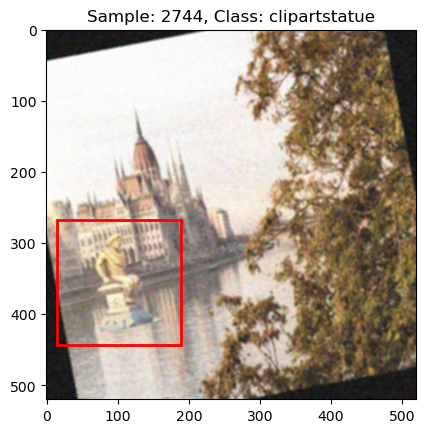

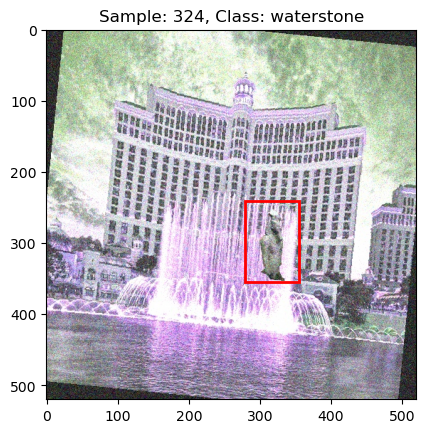

In [188]:
visualize_dataset(train_dataset, 2)